In [5]:
format compact
addpath('/Users/alfordb/Documents/MATLAB/code')

In [5]:
testSequence = 'YXX48';
% Valid choices are: 'WHH', 'MREV8', 'CORY' (Cory-48), 
% 'CORY24', 'YXX48', 'YXX24', 'YXX24S' (symmetrized YXX-24), 'AZ48'

In [132]:
%% Initialize Test Variables

% Potential Test Vars
N = 4;
dim = 2^N ;
cutoffTime = 10e-3;

Ncyc = 20;

% Setup 4-parameter grid
meshing=20; %number of values of each param. to test over

tau = 3e-6;
pulse = 1.5e-6;
Delta = 0;
coupling = 5000;

## Coupling Strength Simulation

In [82]:
couplings = zeros(40);

for i=1:40
    couplings(i) = (i/40)*50000;
end


%% Generate Coupling Matrices

as = generateCoupling(N);


%% Setup Code Normally Run by spinSimNoPlots

% initialize Pauli matrices and transformation operators
z=0.5*sparse([1 0; 0 -1]);x=0.5*sparse( [ 0 1;1 0]); y=1i*0.5*sparse([0 -1;1 0]);
ep=sparse([1 0; 0 0]);
em=sparse([0 0; 0 1]);
id=speye(2);p=sparse([0 1;0 0]);m=sparse([0 0; 1 0]);


% collective spin observables

Z=sparse(dim,dim);
X=sparse(dim,dim);
Y=sparse(dim,dim);

for k=1:N
      Z = Z + mykron(speye(2^(k-1)),z,speye(2^(N-k)));
      X = X + mykron(speye(2^(k-1)),x,speye(2^(N-k)));
      Y = Y + mykron(speye(2^(k-1)),y,speye(2^(N-k)));
end

raw_results = zeros(8,40);
results = zeros(40,1);

%% Simulation

for dipVal=1:length(as)
    dip = as{dipVal};
    for testVal=1:length(couplings)
        coupling = couplings(testVal);
        Tcyc = 6*tau + 4*pulse; % cycle time

        f1 = 1/4/pulse; %Can adjust f1 and w1 by changing 'pulse' variable
        w1 = 2*pi*f1;

        % define system observables and Hamiltonians

        Hdip = getHdip(N, dim, x, y, z, dip);

        %physical Hamiltonian
        Hint = Hdip*coupling + Z*Delta; 

        %Lowest order WAHUHA and MREV hamiltonian
        tc = 6*tau + 4*pulse;

        tcM = 12*tau + 8*pulse;

        % Define Unitaries

        %experimental unitary operators
        Utau=(expm(-1i*Hint*2*pi*tau));
        UhalfTau = (expm(-1i*Hint*pi*tau));
        Ux = (expm(-1i*2*pi*(Hint+f1*X)*pulse));
        Uy = (expm(-1i*2*pi*(Hint+f1*Y)*pulse));
        Uxbar = (expm(-1i*2*pi*(Hint-f1*X)*pulse));
        Uybar = (expm(-1i*2*pi*(Hint-f1*Y)*pulse));

        % SIMULATE SPIN DYNAMICS - - - - - - - - - - - -

        % (Choose desired sequence to test)
        if strcmp(testSequence, 'WHH')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau;
            Havg = (Delta / 3) * (X + Y + Z); 
            testCyc = 12;
            cycleTime = 4 * pulse + 6 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'MREV8')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uybar*Utau*Uxbar*Utau;
            Havg = (Delta / 3) * (X + Z) ;
            testCyc = 6;
            cycleTime = 8 * pulse + 12 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'CORY') % Not currently functional
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 72 * tau + 48 * pulse;

        elseif strcmp(testSequence, 'CORY24')
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;

        elseif strcmp(testSequence, 'YXX48')
            testUnitary = Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        elseif strcmp(testSequence, 'YXX24')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 25*tau + 24*pulse;

        elseif strcmp(testSequence, 'YXX24S')
            testUnitary = Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        elseif strcmp(testSequence, 'AZ48')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Ux*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        end

% SPIN SIMULATION - - - - - - - - -

        for cycleCount=1:Ncyc
            fidelity0 = zeros(Ncyc, 1);

            %Wahuha Sequence
            UcumExp = testUnitary;
            UcumH0 = U0;

            simTime = 0;

            % fidelity metric for unitary operators
            fidelity0(cycleCount) = metric(UcumExp, UcumH0, N); %exp compared to FO
            UcumExp = UcumExp * testUnitary;
            Ucum2 = UcumExp * U0;
            
        end      
        
        raw_results(dipVal,testVal)=fidelity0(Ncyc);
        
    end
end

for d=1:40
    for aa=1:8
        results(d) = results(d)+(1/8)*raw_results(aa,d);
    end
end

In [83]:
hcouplings = load('results12-11-20/Couplings_MREV8_Coupling_magnus_results_11-Dec-2020.mat').testVars;
results_h0 = load('results12-11-20/h0_MREV8_Coupling_magnus_results_11-Dec-2020.mat').results_h0;
results_h2 = load('results12-11-20/h2_MREV8_Coupling_magnus_results_11-Dec-2020.mat').results_h2;
results_h4 = load('results12-11-20/h4_MREV8_Coupling_magnus_results_11-Dec-2020.mat').results_h4;

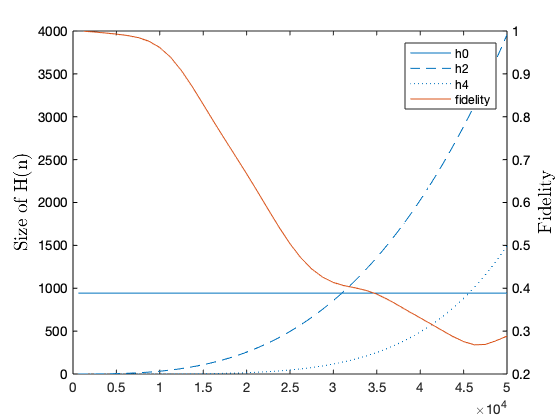

In [84]:
yyaxis left
plot(hcouplings,10.^results_h0(:,1))
hold on
plot(hcouplings,10.^results_h2(:,1))
plot(hcouplings,10.^results_h4(:,1))
h=ylabel('Size of H(n)');
set(h,'interpreter','latex','fontsize',14);
set(gca,'ycolor','black')

yyaxis right
plot(couplings(:,1),results(:,1))
h=ylabel('Fidelity');
set(h,'interpreter','latex','fontsize',14);
set(gca,'ycolor','black')

legend('h0','h2','h4','fidelity')

In [85]:
filename = 'MREV8_fidelity_coupling.mat'
save(filename,'couplings','results')

filename =
    'MREV8_fidelity_coupling.mat'


## Tau Simulation

In [133]:
taus = zeros(40);

for i=1:40
    taus(i) = (i/40)*20e-6;
end


%% Generate Coupling Matrices

as = generateCoupling(N);


%% Setup Code Normally Run by spinSimNoPlots

% initialize Pauli matrices and transformation operators
z=0.5*sparse([1 0; 0 -1]);x=0.5*sparse( [ 0 1;1 0]); y=1i*0.5*sparse([0 -1;1 0]);
ep=sparse([1 0; 0 0]);
em=sparse([0 0; 0 1]);
id=speye(2);p=sparse([0 1;0 0]);m=sparse([0 0; 1 0]);


% collective spin observables

Z=sparse(dim,dim);
X=sparse(dim,dim);
Y=sparse(dim,dim);

for k=1:N
      Z = Z + mykron(speye(2^(k-1)),z,speye(2^(N-k)));
      X = X + mykron(speye(2^(k-1)),x,speye(2^(N-k)));
      Y = Y + mykron(speye(2^(k-1)),y,speye(2^(N-k)));
end

raw_results = zeros(8,40);
results = zeros(40,1);

%% Simulation

for dipVal=1:length(as)
    dip = as{dipVal};
    for testVal=1:length(taus)
        tau = taus(testVal);
        Tcyc = 6*tau + 4*pulse; % cycle time

        f1 = 1/4/pulse; %Can adjust f1 and w1 by changing 'pulse' variable
        w1 = 2*pi*f1;

        % define system observables and Hamiltonians

        Hdip = getHdip(N, dim, x, y, z, dip);

        %physical Hamiltonian
        Hint = Hdip*coupling + Z*Delta; 

        %Lowest order WAHUHA and MREV hamiltonian
        tc = 6*tau + 4*pulse;

        tcM = 12*tau + 8*pulse;

        % Define Unitaries

        %experimental unitary operators
        Utau=(expm(-1i*Hint*2*pi*tau));
        UhalfTau = (expm(-1i*Hint*pi*tau));
        Ux = (expm(-1i*2*pi*(Hint+f1*X)*pulse));
        Uy = (expm(-1i*2*pi*(Hint+f1*Y)*pulse));
        Uxbar = (expm(-1i*2*pi*(Hint-f1*X)*pulse));
        Uybar = (expm(-1i*2*pi*(Hint-f1*Y)*pulse));

        % SIMULATE SPIN DYNAMICS - - - - - - - - - - - -

        % (Choose desired sequence to test)
        if strcmp(testSequence, 'WHH')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau;
            Havg = (Delta / 3) * (X + Y + Z); 
            testCyc = 12;
            cycleTime = 4 * pulse + 6 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'MREV8')
            testUnitary = Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uybar*Utau*Uxbar*Utau;
            Havg = (Delta / 3) * (X + Z) ;
            testCyc = 6;
            cycleTime = 8 * pulse + 12 * tau;
            U0 = expm(-1i*Havg*2*pi*cycleTime);

        elseif strcmp(testSequence, 'CORY') % Not currently functional
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uy*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uybar*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 72 * tau + 48 * pulse;

        elseif strcmp(testSequence, 'CORY24')
            testUnitary = Utau*Ux*Utau*Uybar*Utau*Utau*Ux*Utau*Uy*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uybar*Utau*Uxbar*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Ux*Utau*Uybar*Utau*Utau*Uxbar*Utau*Uybar*Utau*Utau*Uy*Utau*Ux*Utau*Utau*Uy*Utau*Uxbar*Utau*Utau*Uy*Utau*Ux*Utau;

        elseif strcmp(testSequence, 'YXX48')
            testUnitary = Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        elseif strcmp(testSequence, 'YXX24')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 25*tau + 24*pulse;

        elseif strcmp(testSequence, 'YXX24S')
            testUnitary = Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uy*Utau*Uxbar*Utau*Ux*Utau*Uybar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        elseif strcmp(testSequence, 'AZ48')
            testUnitary = Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau*Uxbar*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uy*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Ux*Utau*Ux*Utau*Uybar*Utau*Uy*Utau*Uy*Utau*Ux*Utau*Uy*Utau*Uy*Utau*Uxbar*Utau;
            Havg = 0;
            testCyc = 1;
            U0 = 1;
            cycleTime = 49*tau + 48*pulse;

        end

% SPIN SIMULATION - - - - - - - - -

        for cycleCount=1:Ncyc
            fidelity0 = zeros(Ncyc, 1);

            %Wahuha Sequence
            UcumExp = testUnitary;
            UcumH0 = U0;

            simTime = 0;

            % fidelity metric for unitary operators
            fidelity0(cycleCount) = metric(UcumExp, UcumH0, N); %exp compared to FO
            UcumExp = UcumExp * testUnitary;
            Ucum2 = UcumExp * U0;
            
        end      
        
        raw_results(dipVal,testVal)=fidelity0(Ncyc);
        
    end
end

for d=1:40
    for aa=1:8
        results(d) = results(d)+(1/8)*raw_results(aa,d);
    end
end

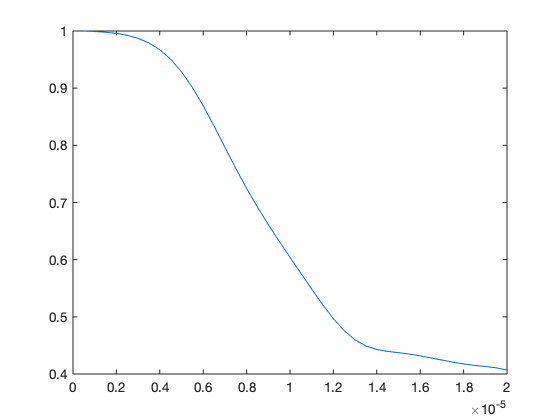

In [134]:
plot(taus(:,1),results(:,1))

In [129]:
filename = strcat(testSequence,'_fidelity_tau.mat')
save(filename,'taus','results')

filename =
    'YXX24S_fidelity_tau.mat'
